In [5]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
INPUT_PATH = "/content/drive/MyDrive/CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

fear has 75 number of images
surprise has 249 number of images
sadness has 84 number of images
anger has 135 number of images
happy has 207 number of images


`sadness` and `fear` has very low number of images as compared to other classes

In [7]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

### Data Preprocessing

I first make the data compatible for neural nets

In [8]:
INPUT_PATH = "/content/drive/MyDrive/CK+48/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [9]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [10]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [11]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

fear has 25 samples
surprise has 83 samples
sadness has 28 samples
anger has 45 samples
happy has 69 samples


In [12]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

X.shape, y.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((250, 3, 48, 48, 1), (250, 5))

In [13]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True, random_state=42)
X_train.shape, X_valid.shape

((175, 3, 48, 48, 1), (75, 3, 48, 48, 1))

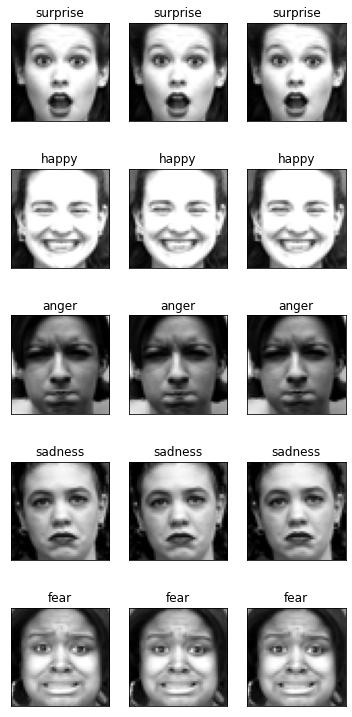

In [15]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [16]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [17]:
def build_dcnn(input_shape, show_arch=True):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.3, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.3, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [18]:
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 32
epochs = 200

In [20]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 3, 512)           4691904   
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 3, 256)           656384    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

In [21]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/200
6/6 [==============================] - 24s 646ms/step - loss: 3.1700 - accuracy: 0.2114 - val_loss: 1.7043 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 102ms/step - loss: 3.0793 - accuracy: 0.2114 - val_loss: 1.7381 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 104ms/step - loss: 3.2883 - accuracy: 0.2057 - val_loss: 1.6927 - val_accuracy: 0.1067 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 102ms/step - loss: 2.7849 - accuracy: 0.2400 - val_loss: 1.6331 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 103ms/step - loss: 3.0381 - accuracy: 0.1943 - val_loss: 1.6525 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 101ms/step - loss: 2.7941 - accuracy: 0.2286 - val_loss: 1.7285 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 107ms/step - loss: 2.

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Saved model to disk


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

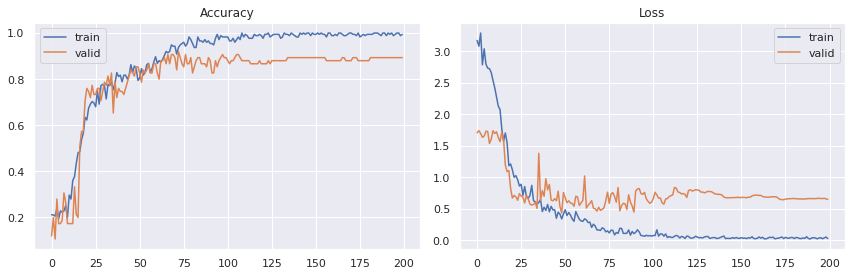

In [23]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

`The fluctuations in the epoch metrics is due to the fact that we have very low data for such a complex task.`

3/3 [==============================] - 0s 29ms/step
total wrong validation predictions: 8


              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       1.00      0.95      0.98        21
           2       0.85      0.85      0.85        13
           3       0.70      0.88      0.78         8
           4       0.75      0.75      0.75         8

    accuracy                           0.89        75
   macro avg       0.85      0.87      0.86        75
weighted avg       0.90      0.89      0.90        75



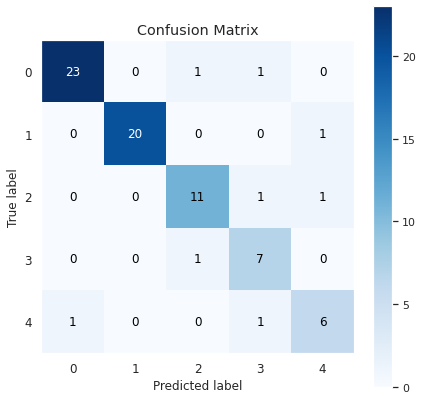

In [26]:
yhat = model.predict(X_valid)
yhat_classes = np.argmax(yhat, axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_classes, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_classes)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_classes))

`If we have more data to train then we will get better and more generalized model.`

In [ ]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]), size=15, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    pred_emotion = label_emotion_mapper[model.predict_classes(np.expand_dims(X_valid[idx], axis=0))[0]]
    
    for j in range(3):
        i += 1
        ax = pyplot.subplot(15,3,i)
        sample_img = X_valid[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

In [ ]:
# Saving Model weights and json
model_json_file = './model.json'
model_weights_file = './model.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [ ]:
# default harcascade 
face_cascade = cv2.CascadeClassifier('../input/haarcascade-frontalface-defaultxml/haarcascade_frontalface_default.xml')

In [ ]:
%run -i './scripts/enable_widgets.py'

In [ ]:
import cv2
from IPython.display import display, clear_output
from ipywidgets import widgets

def capture_frame(camera_port=0):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(camera_port)
    
    # Capture a single frame from the camera
    ret, frame = cap.read()
    
    # Release the VideoCapture object
    cap.release()
    
    return frame

In [ ]:
button_widget = widgets.Button(description='Start/Stop Camera')

In [ ]:
def on_button_clicked(b):
    global camera_running
    if camera_running:
        camera_running = False
    else:
        camera_running = True
        while camera_running:
            frame = capture_frame()
            clear_output(wait=True)
            display(button_widget)
            display(widgets.Image(format='jpeg', value=cv2.imencode('.jpg', frame)[1].tobytes()))

In [ ]:
button_widget.on_click(on_button_clicked)

In [ ]:
display(button_widget)

In [ ]:
cap = cv2.VideoCapture(1)
import copy

while True:
    
    ret, frame = cap.read()
    img = copy.deepcopy(frame)
    if img.shape[0] == 0 or img.shape[1] == 0:
         # handle error (e.g. print an error message and exit the program)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    #img = copy.deepcopy(frame)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image to RGB format
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        fc = gray[y:y+h, x:x+w]  
       
        roi = cv2.resize(fc, (48,48))
        new_roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
        new_roi = new_roi.reshape(1, 3, 48, 48, 1)
        #pred = loaded_model.predict(new_roi[np.newaxis, :, :, np.newaxis])
        
        #roi = cv2.resize(fc, (48,48))
        #roi = np.expand_dims(roi, axis=0)  # Add the missing "3" dimension
        #pred = loaded_model.predict(roi)
        
       # roi = cv2.resize(fc, (48,48))
        #roi = roi.reshape(1, 3, 48, 48, 1)  # Reshape the input to the correct shape
        pred = loaded_model.predict(new_roi)
        
       # roi = cv2.resize(fc, (48,48))
        #roi = roi.reshape(1, 1, 48, 48, 1)  # Reshape the input to the correct shape
        #pred = loaded_model.predict(roi)
        '''text_idx=np.argmax(pred)
        text_list = ['happy', 'surprise', 'anger', 'sadness', 'fear']
        if text_idx == 0:
            text= text_list[0]
        if text_idx == 1:
            text= text_list[1]
        elif text_idx == 2:
            text= text_list[2]
        elif text_idx == 3:
            text= text_list[3]
        elif text_idx == 4:
            text= text_list[4]
        '''
        #print(np.argmax(pred))
        text = label_emotion_mapper[np.argmax(pred)]
        cv2.putText(img, text, (x, y-5),
           cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
    cv2.imshow("frame", img)
    key = cv2.waitKey(1) & 0xFF
    if key== ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()